<h1><center> AML Detection Challenge
    <br>
    <br> Starter Solution Notebook

<h3>Imports
Include URLs to relevant examples

In [0]:
import pandas as pd                    #Data structuring and analysis
import numpy as np                     #Arrays, matrices, linear algebra
import networkx as nx                  #Network / graph analysis
import sklearn as sk                   #Data analysis, machine learning

import copy
import tqdm                            #Utility to display progress bar
import datetime                        #Date and time representations
import seaborn as sns                  #Plotting and visualisation
from matplotlib import pyplot as plt   #Plotting and visualisation

<h3> Load Data

In [2]:
print('Downloading data locally')
!curl https://raw.githubusercontent.com/PaulMercerAI/AML19/master/data/20191111_Accounts.csv.xz -L | xzcat > accounts.csv
!curl https://raw.githubusercontent.com/PaulMercerAI/AML19/master/data/20191111_Transactions.csv.xz -L | xzcat > transactions.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  302k  100  302k    0     0  54340      0  0:00:05  0:00:05 --:--:-- 73899
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5022k  100 5022k    0     0  5052k      0 --:--:-- --:--:-- --:--:-- 5047k


In [4]:
#Load accounts data file
ac = pd.read_csv("accounts.csv")
print('Number of accounts: ', len(ac))

#Load transactions data file 
date = ['timestamp']
tx = pd.read_csv("transactions.csv", parse_dates=date)
print('Number of transactions: ', len(tx))
print('Number of labelled transactions: ', len(tx[tx.is_suspx!='Unknown']))

Number of accounts:  10000
Number of transactions:  515721
Number of labelled transactions:  257787


<h3>Inspect Data

In [5]:
# Printing top 10 rows of accounts data
print('Top 10 rows from the accounts dataset:')
display(ac.head(10))

#printing top 10 rows of transactions data
print('\nTop 10 rows from the transactions dataset:')
display(tx.head(10))

Top 10 rows from the accounts dataset:


,acct_id,initial_deposit,cust_forname,cust_surname,cust_gender,cust_birthdate
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,92221.09,Terry,Knight,m,1971-12-06
1,23b8c1e9-3924-46de-beb1-3b9046685257,87897.72,Lesley,Walsh,f,1954-02-06
2,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,71028.58,Lynne,Taylor,f,1965-04-12
3,972a8469-1641-4f82-8b9d-2434e465e150,62945.84,Naomi,Hill,f,1958-11-16
4,17fc695a-07a0-4a6e-8822-e8f36c031199,75563.74,Abbie,Jones,f,1976-03-31
5,9a1de644-815e-46d1-bb8f-aa1837f8a88b,70246.71,Brenda,Clarke,f,1998-06-12
6,b74d0fb1-32e7-4629-8fad-c1a606cb0fb3,89189.93,Liam,Howard,m,1960-11-04
7,6b65a6a4-8b81-48f6-b38a-088ca65ed389,65165.64,Benjamin,Graham,m,1981-09-02
8,47378190-96da-4dac-b2ff-5d2a386ecbe0,73829.85,Alan,Carter,m,1980-06-28
9,c241330b-01a9-471f-9e8a-774bcf36d58b,79169.10,Bryan,Riley,m,1982-03-19



Top 10 rows from the transactions dataset:


,id,timestamp,sender_account,receiver_account,amount,is_suspx,alert_type,alert_id
0,1,2017-01-01 00:00:00+00:00,95eb44d9-8459-4302-8d1d-036e0d08da99,614996d1-01db-40b4-8422-1bf274faebdd,413.96,Unknown,Unknown,Unknown
1,2,2017-01-01 00:00:00+00:00,8735b2bb-35bd-41ea-8799-6e3ba360c4cb,c5798f5d-9690-40b0-9182-88dd16965a15,334.40,Unknown,Unknown,Unknown
2,3,2017-01-01 00:00:00+00:00,6a036e2f-5108-4482-bdb7-7a79990501f8,1eac66fe-fc30-477c-8f58-ed08f5b917b1,455.65,Unknown,Unknown,Unknown
3,4,2017-01-01 00:00:00+00:00,d298404d-96f6-4fa1-9951-9ab3bf5eaf8e,4aeeccef-871c-4a58-9334-dce93145d4c5,351.14,Unknown,Unknown,Unknown
4,5,2017-01-01 00:00:00+00:00,8a55a14b-51f5-48f9-bc15-ae1fefda21b2,53ae0bce-0ccc-4432-a913-ed3b7f5c62cc,438.76,Unknown,Unknown,Unknown
5,6,2017-01-01 00:00:00+00:00,2b5997f2-c447-4e3f-8525-c1b4f73c6a1f,0570ea72-a167-40f7-9de8-f62bd45f8e7f,413.58,False,-,-
6,7,2017-01-01 00:00:00+00:00,8e687e83-0023-43a5-b8b0-42dac52a0570,a8449e0b-2ac2-4c1e-8a83-e68d46eed033,422.26,False,-,-
7,8,2017-01-01 00:00:00+00:00,d8e06ea2-de5e-48e5-bb3a-3e15ef1920da,47d9dd10-272d-4ace-bfd0-dce0612c3b0d,338.46,False,-,-
8,9,2017-01-01 00:00:00+00:00,1a0c0048-7108-4569-908d-6ac75baca439,46a1c19b-d238-4804-8a8c-e2d7bdeb7527,330.01,Unknown,Unknown,Unknown
9,10,2017-01-01 00:00:00+00:00,70b3e6df-c9c3-4dd8-a5a7-970558e8f1db,7aa83419-7479-4994-a2fe-9cb4fcec1791,469.80,False,-,-


Data Dictionary

|Field Name|Data Type|Description|
|----------|---------|-----------|
|id|Int|Id number of the transaction|
|timestamp|Date Type|Time at which the transaction took place|
|sender_account|String|Unique Id the account from which the transaction was made. This will match to the accounts table.|
|receiver_account|String|Unique Id of account to which the transaction was made. This will match to the accounts table.|
|amount|Float|The value of the transaction made.|
|is_suspx|String|Flags if the transaction is suspicious. This is a target column.|
|alert_id|String|Id of the alert that has been generated.|
|alert_type|String|Type of alert that has been generated. This is a target column.|

<h3>Inspect an alert

In [22]:
# Next command gets the first A4 type alert id. 
# Hopefully the filter for A4 type alerts is obvious. 
# Then we select just the alert_id column to get an array (matrix with a single x dimension) of length len(tx)
# [0:1] means take 1 element from the array starting at element 0, but that returns an array, so to get just the value we add [0]
id = tx[tx.alert_type=='A4'].alert_id.unique()[0:1][0]
print("Inspecting alert id:"+id)
tx[tx.alert_id==id] 
#A4 type was selected because the sender/receiver arrangement is more interesting than usual for this type

Inspecting alert id:36


,id,timestamp,sender_account,receiver_account,amount,is_suspx,alert_type,alert_id
484,485,2017-01-01 00:00:00+00:00,9458054e-c287-4f06-9050-f7efc1235c91,37663e35-cdba-4cac-be85-f617f17e993d,350.40,True,A4,36
42719,42720,2017-03-01 00:00:00+00:00,8bc85d37-09cc-4f1a-9c38-7c2a1243e838,37663e35-cdba-4cac-be85-f617f17e993d,341.73,True,A4,36
46049,46050,2017-03-06 00:00:00+00:00,202a9ced-885a-4b35-9b8e-e298f561f4c3,37663e35-cdba-4cac-be85-f617f17e993d,354.55,True,A4,36
276920,276921,2018-01-22 00:00:00+00:00,37663e35-cdba-4cac-be85-f617f17e993d,6d3026db-20f8-460c-bf10-545a1dd3c5d2,312.47,True,A4,36
367190,367191,2018-05-28 00:00:00+00:00,37663e35-cdba-4cac-be85-f617f17e993d,3ad96cc4-c0ac-4a64-a426-d1c1feb24920,313.69,True,A4,36
438425,438426,2018-09-05 00:00:00+00:00,37663e35-cdba-4cac-be85-f617f17e993d,c9ceacdb-9f24-4788-805c-c2d749fa68d6,313.14,True,A4,36


<h3>Visualise amount densities

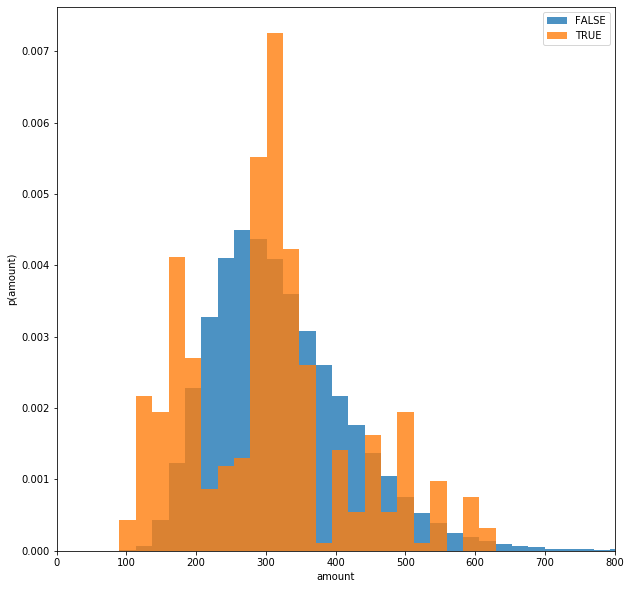

In [23]:
tx_0 = tx[tx['is_suspx']=='False'] #create a new matrix with the subset of transactions defined by the filter
tx_1 = tx[tx['is_suspx']=='True']  

#Don't worry too much about this. Just play with the density and alpha values to see what they do.
fig, ax = plt.subplots(figsize=(10,10))
_, bins, _ = plt.hist(tx_0['amount'], bins=100, density=True, alpha=0.8, label='FALSE')
_ = plt.hist(tx_1['amount'], bins=bins, alpha=0.8, density=True, label='TRUE')
plt.legend(loc='best')
plt.xlim([0,800])
plt.xlabel('amount'), plt.ylabel('p(amount)')
plt.show()
# https://matplotlib.org/api/pyplot_api.html

<h3>Visualise alert patterns

Sample of A3 Alert_Types: ['83' '177' '27' '18' '78' '105']


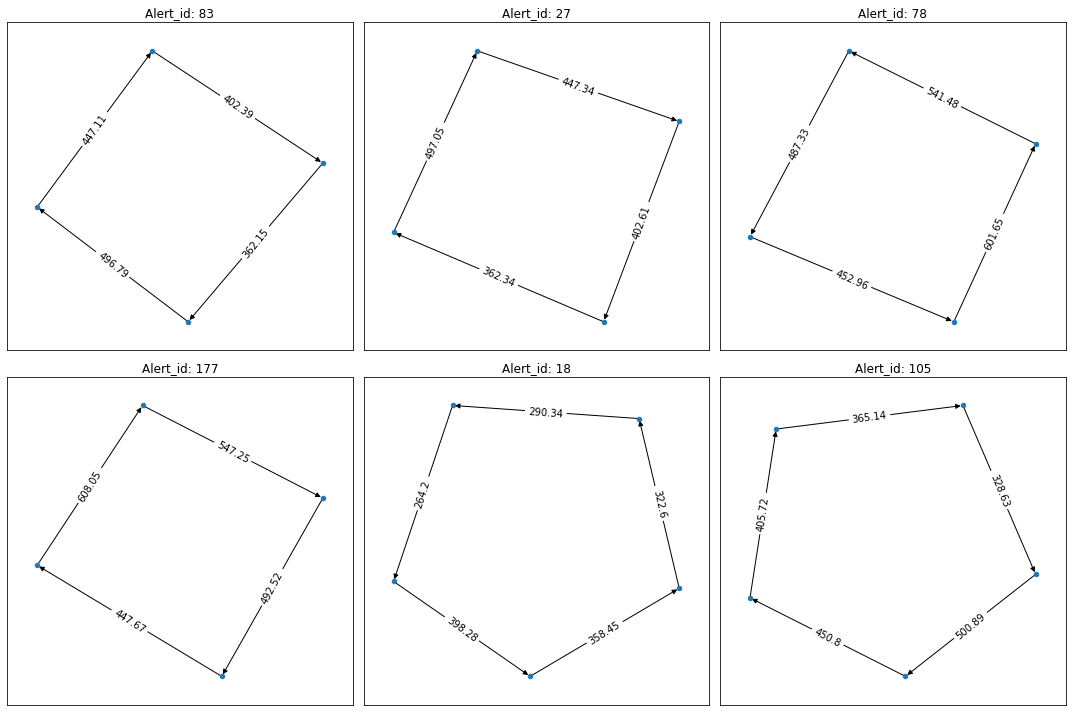

In [24]:
# Take the first 6 alert IDs where alert type is A3
sample_a3 = tx[tx.alert_type=='A3'].alert_id.unique()[0:6] 
print("Sample of A3 Alert_Types:", sample_a3)

fig, ax = plt.subplots(2, 3, figsize=(15,10))

for count, alert in enumerate(sample_a3):

  # Taking a sample alert and generating a graph of the transactions where accounts are nodes and amounts are weights
  edgelist = tx.loc[tx.alert_id==alert,['sender_account', 'receiver_account', 'amount']].values.tolist()

  # Create a directional graph using the edge list
  graph = nx.DiGraph()
  edgelist_tuple = [tuple(x) for x in edgelist]
  graph.add_weighted_edges_from(edgelist_tuple)

  # Plotting the directional graph

  pos = nx.spring_layout(graph)
  nx.draw_networkx(graph, pos, with_labels=False, node_size = 20, ax=ax[count%2, count//2])

  labels = nx.get_edge_attributes(graph,'weight')
  nx.draw_networkx_edge_labels(graph,edge_labels=labels, pos=pos, ax=ax[count%2, count//2])
  ax[count%2, count//2].set_title(f'Alert_id: {alert}')

plt.tight_layout()
plt.show()

<h3>Join balance with transactions

In [25]:
#initialise balance
balance = dict(zip(ac.acct_id, ac.initial_deposit))

#monitor debits and credits
for i in tqdm.tqdm(range(len(tx))):
    
    #debit sender account
    sender = tx.at[i,'sender_account']
    sender_balance_pre = balance[sender]
    sender_balance_post = sender_balance_pre - tx.at[i,'amount']
    
    #credit receiver account
    receiver = tx.at[i,'receiver_account']
    receiver_balance_pre = balance[receiver]
    receiver_balance_post = receiver_balance_pre + tx.loc[i,'amount']
    
    #create new columns in transactions
    tx.at[i,'sender_balance_pre'] = sender_balance_pre
    tx.at[i,'sender_balance_post'] = sender_balance_post
    tx.at[i,'receiver_balance_pre'] = receiver_balance_pre
    tx.at[i,'receiver_balance_post'] = receiver_balance_post
    
    #update balance dictionary
    balance[sender] = sender_balance_post
    balance[receiver] = receiver_balance_post
    

100%|██████████| 515721/515721 [00:27<00:00, 18828.91it/s]


Visualise balance profiles

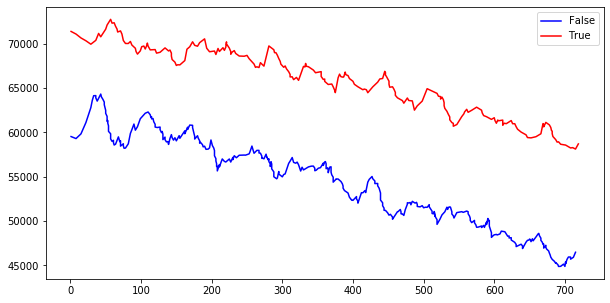

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
a = []
a.append('b10e91b4-6ae5-4c9d-b9d3-cba066a0835e') #supicious instance
a.append('00cdcce8-17ed-4eb8-9739-1cff8cc99052') #not suspicious instance
label = ['False', 'True']
col = ['blue', 'red']

for i in range(2):
    temp = tx[tx['sender_account']==a[i]]
    bal = temp['sender_balance_pre']
    tim = (temp['timestamp'].dt.date - datetime.date(2017,1,1)).dt.days
    plt.plot(tim,bal,color=col[i],label=label[i])
plt.legend(loc='best')
plt.show()


<h3>Generate Amount Profile Features

In [27]:
def roll_count(x,w):
    return x.rolling(w).count()
def roll_sum(x,w):
    return x.rolling(w).sum()
def roll_mean(x,w):
    return x.rolling(w).mean()
def expand_count(x):
    return x.expanding().count()
def expand_sum(x):
    return x.expanding().sum()
def expand_mean(x):
    return x.expanding().mean()

# 7 day rolling profiles
print('Generating rolling profiles...')
tx.set_index('timestamp',inplace=True)
print('.....count')
tx['s_rolling_count_7D'] = tx.groupby('sender_account').amount.transform(roll_count, '7D')
print('.....sum amount')
tx['s_rolling_sum_7D'] = tx.groupby('sender_account').amount.transform(roll_sum, '7D')
print('.....mean amount')
tx['s_rolling_mean_7D'] = tx.groupby('sender_account').amount.transform(roll_mean, '7D')
#tx['sr_rolling_count_7D'] = tx.groupby(['sender_account','receiver_account']).amount.transform(roll_count, '7D')
#tx['sr_rolling_sum_7D'] = tx.groupby(['sender_account','receiver_account']).amount.transform(roll_sum, '7D')
#tx['sr_rolling_mean_7D'] = tx.groupby(['sender_account','receiver_account']).amount.transform(roll_mean, '7D')
tx.reset_index(inplace=True)

# expanding profiles
#print('Generating expanding profiles...')
#tx['s_expanding_count'] = tx.groupby('sender_account').amount.transform(expand_count)
#tx['s_expanding_sum'] = tx.groupby('sender_account').amount.transform(expand_sum)
#tx['s_expanding_mean'] = tx.groupby('sender_account').amount.transform(expand_mean)
#tx['sr_expanding_count'] = tx.groupby(['sender_account','receiver_account']).amount.transform(expand_count)
#tx['sr_expanding_sum'] = tx.groupby(['sender_account','receiver_account']).amount.transform(expand_sum)
#tx['sr_expanding_mean'] = tx.groupby(['sender_account','receiver_account']).amount.transform(expand_mean)

Generating rolling profiles...
.....count
.....sum amount
.....mean amount


<h3>Network Features

In [0]:
# This block takes quite a long time to run
def add_feature(tx,x,s):
    a = dict(x)
    for i in range(len(tx)):
        o = a.get(tx.at[i,'sender_account'])
        tx.at[i,'nameOrig'+s] = o
        d = a.get(tx.at[i,'receiver_account'])
        tx.at[i,'nameDest'+s] = d
    return (tx)
    
MG = nx.from_pandas_edgelist(tx, 'sender_account', 'receiver_account', create_using=nx.DiGraph())

degree = MG.degree()
tx = add_feature(tx,degree,'_degree')
print('degree feature added')

out_degree = MG.out_degree()
tx = add_feature(tx,out_degree,'_outdegree')
print('out-degree feature added')

in_degree = MG.in_degree()
tx = add_feature(tx,in_degree,'_indegree')
print('in-degree feature added')

G = nx.Graph(MG)
triangles = nx.triangles(G)
tx = add_feature(tx,triangles,'_triangles')
print('triangles feature added')

clust_coefficients = nx.clustering(G)
tx = add_feature(tx,clust_coefficients,'_clust')
print('clustering coeff feature added')
    
degree_centrality = nx.degree_centrality(G)
tx = add_feature(tx,degree_centrality,'_degcentral')
print('degree centrality feature added')

eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
tx = add_feature(tx,eigenvector_centrality,'_eigcentral')
print('eigenvector centrality feature added')

betweenness_centrality = nx.betweenness_centrality(G)
tx = add_feature(tx,betweenness_centrality,'_bwcentral')
print('betweenness centrality feature added')

closeness_centrality = nx.closeness_centrality(G)
tx = add_feature(tx,closeness_centrality,'_closecentral')
print('closeness centrality feature added')

katz_centrality = nx.katz_centrality_numpy(G)
tx = add_feature(tx,katz_centrality,'_katzcentral')
print('katz centrality feature added')

load_centrality = nx.load_centrality(G)
tx = add_feature(tx,load_centrality,'_loadcentral')
print('load centrality feature added')

harmonic_centrality = nx.harmonic_centrality(G)
tx = add_feature(tx,harmonic_centrality,'_harmoniccentral')
print('harmonic centrality feature added')

    

degree feature added
out-degree feature added
in-degree feature added
triangles feature added
clustering coeff feature added
degree centrality feature added
eigenvector centrality feature added
betweenness centrality feature added


<h3> (Supervised) Machine Learning!

Prep data

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

X = copy.deepcopy(tx)
y = copy.deepcopy(tx.is_suspx)

predict_df = X[X.is_suspx=='Unknown']
y = y[X.is_suspx!='Unknown']
y = y.factorize()[0]
X = X[X.is_suspx!='Unknown']

X = X.loc[:, ['amount', 's_rolling_count_7D', 's_rolling_sum_7D']]
predict_df = predict_df.loc[:, ['amount', 's_rolling_count_7D', 's_rolling_sum_7D']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

Build & validate model

In [0]:
#add terminology cell in notebook
gb = GradientBoostingClassifier(
    max_depth=3,
    n_estimators=100,
    learning_rate=0.2
)
gb.fit(X_train, y_train)

print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))

In [0]:
predictions = gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))

Class imbalance problem: try (random) undersampling the majority (is_suspx=False) class